In [192]:
import numpy as np
import requests
import io
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import rotate
%matplotlib inline
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
import imgaug as ia
import imgaug.augmenters as iaa
import torchmetrics
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75

# Batch Sampler

In [193]:
class BatchSampler():
  """
  Implements an iterable which given a torch dataset and a batch_size
  will produce batches of data of that given size. The batches are
  returned as tuples in the form (images, labels).
  Can produce balanced batches, where each batch will have an equal 
  amount of samples from each class in the dataset. If your dataset is heavily
  imbalanced, this might mean throwing away a lot of samples from 
  over-represented classes!
  """

  def __init__(self, batch_size, dataset, balanced=False):
    self.batch_size = batch_size
    self.dataset = dataset
    self.balanced = balanced
    if self.balanced:
      # Counting the ocurrence of the class labels:
      unique, counts = np.unique(self.dataset.targets, return_counts=True) 
      indexes = []
      # Sampling an equal amount from each class:
      for i in range(len(unique)):
        indexes.append(np.random.choice(np.where(self.dataset.targets == i)[0], size=counts.min(), replace=False))
      # Setting the indexes we will sample from later:
      self.indexes = np.concatenate(indexes)
    else:
      # Setting the indexes we will sample from later (all indexes):
      self.indexes = [i for i in range(len(dataset))]


  def __len__(self):
    return (len(self.indexes) // self.batch_size) + 1
  
  def shuffle(self):
    # We do not need to shuffle if we use the balanced sampling method.
    # Shuffling is already done when making the balanced samples.
    if not self.balanced:
      random.shuffle(self.indexes)
    
  def __iter__(self):
    remaining = False
    self.shuffle()
    # Go over the datset in steps of 'self.batch_size':
    for i in range(0, len(self.indexes), self.batch_size):
        imgs, labels = [], []
        # If our current batch is larger than the remaining data, we quit:
        if i + self.batch_size > len(self.indexes):
          remaining = True
          break
        # If not, we yield a complete batch:
        else:
          # Getting a list of samples from the dataset, given the indexes we defined:
          X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, i + self.batch_size)]
          Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, i + self.batch_size)]
          # Stacking all the samples and returning the target labels as a tensor:
          yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()
    # If there is still data left that was not a full batch:
    if remaining:
      # Return the last batch (smaller than batch_size):
      X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, len(self.indexes))]
      Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, len(self.indexes))]
      yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()


# ImageDataset function
Conmverts numpy arrays into datasets and can also convert them into torch tensors

In [194]:
class ImageDataset(Dataset):
  """
  Creates a DataSet from numpy arrays while keeping the data 
  in the more efficient numpy arrays for as long as possible and only
  converting to torchtensors when needed (torch tensors are the objects used
  to pass the data through the neural network and apply weights).
  """
  torch_transform = transforms.Compose([
    transforms.CenterCrop(100),
    transforms.RandomHorizontalFlip(p=0.4),
   
    
    ])
  def __init__(self, x, y, transform=torch_transform, target_transform=None):
    self.targets = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = torch.from_numpy(self.imgs[idx] / 255).float()
    label = self.targets[idx]
    return image, label

def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 


# Class labels

class_labels = {0: 'Atelectasis',
                1: 'Effusion',
                2: 'Infiltration',
                3: 'No Finding',
                4: 'Nodule',
                5: 'Pneumothorax'}

# Training and test data

In [195]:
#@title
# Downloading the labels of each image:
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/i6MvQ8nqoiQ9Tci/download')
test_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/wLXiOjVAW4AWlXY/download')

In [196]:
#@title
# Downloading the images:
train_x = np.load('./data_train_set.npy')
test_x = np.load('./data_test_set.npy')

# Data distribution

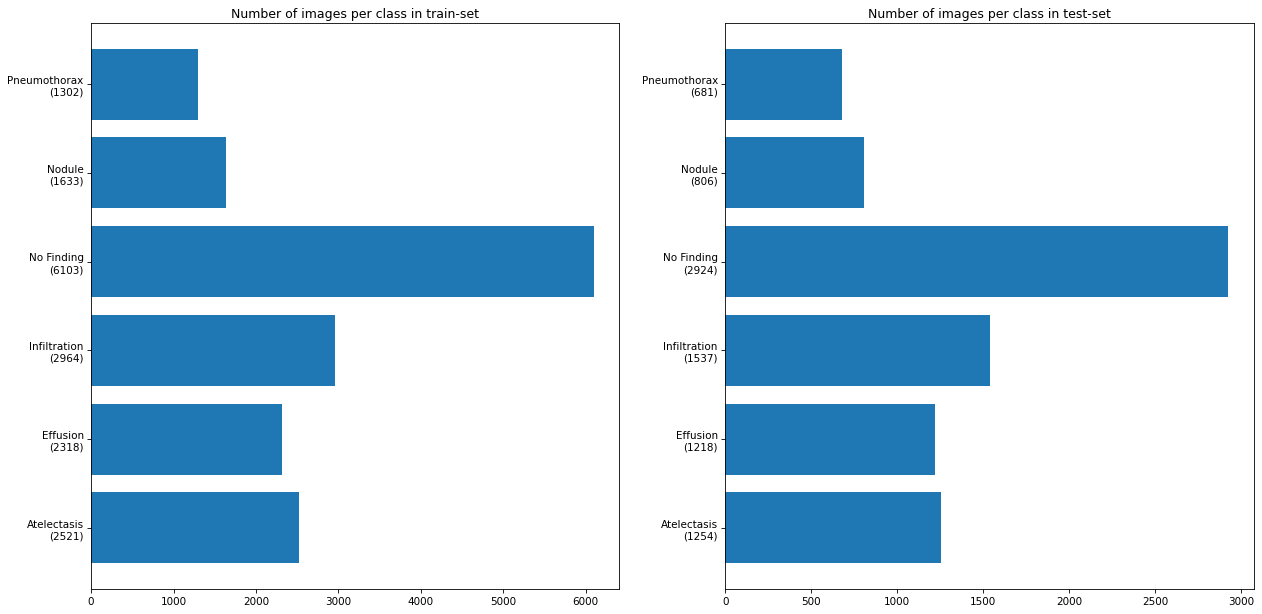

In [197]:
#@title
# Plotting the label distribution in train/test set:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])

unique, counts = np.unique(train_y, return_counts=True) 
ax[0].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[0].set_title('Number of images per class in train-set')

unique, counts = np.unique(test_y, return_counts=True) 
ax[1].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[1].set_title('Number of images per class in test-set');

# Example images

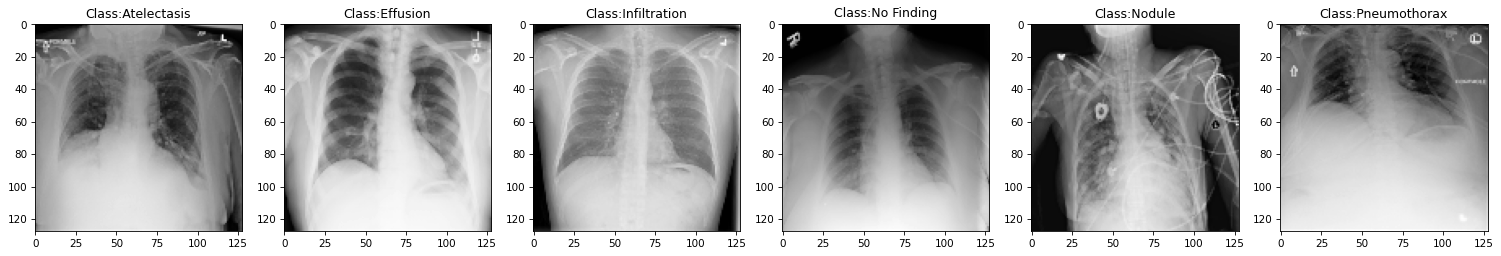

In [198]:
#@title
# Plotting some images
unique_labels = set(class_labels.keys())
fig, ax = plt.subplots(ncols=len(unique_labels), figsize=[25,5])

for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  ax[k].imshow(train_x[ind].reshape(128,128), cmap='gray')
  ax[k].set_title(f'Class:{class_labels[train_y[ind]]}')

# Creating torch datasets and defining device

In [199]:
torch_transform = transforms.Compose([
    transforms.CenterCrop(100),
    transforms.RandomHorizontalFlip(p=0.4),
   
    
    ])
train_dataset = ImageDataset(train_x, train_y, transform=torch_transform)
test_dataset = ImageDataset(test_x, test_y, transform=torch_transform)

In [200]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device 

'cuda'

In [201]:
for i in tqdm(train_dataset):
    images, labels = i

100%|██████████| 16841/16841 [00:00<00:00, 19720.24it/s]


In [202]:
print(images.shape)

torch.Size([1, 128, 128])


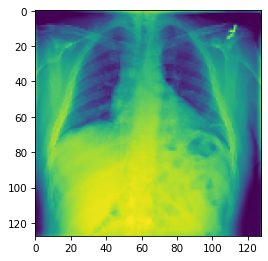

In [203]:
plt.imshow(images[0].reshape(128,128));

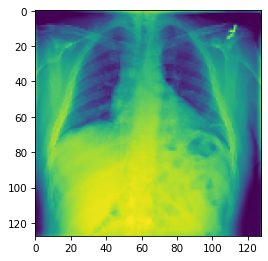

In [204]:
plt.imshow(images[0].squeeze())

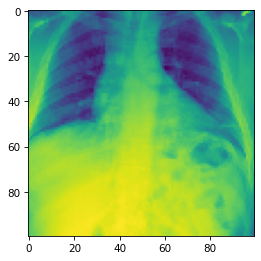

In [205]:
import torchvision.transforms as transforms

transforms_torch = transforms.Compose([
    #transforms.Resize((256, 256)), 
    transforms.CenterCrop(100),
    #transforms.ToPILImage(),
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandAugment(num_ops=2, magnitude=2)
    #transforms.ToTensor(),
])
aug = transforms_torch(images[0])
plt.imshow(aug);

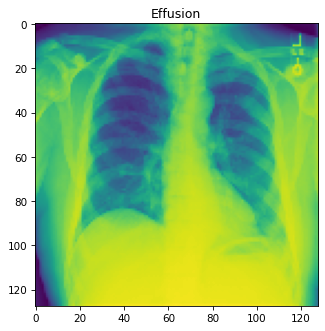

In [206]:
ax = plt.subplots(ncols= 1, figsize=[5,5])

image = 6
classification = class_labels[train_y[image]]

ax[1].imshow(train_x[image].squeeze())
ax[1].set_title(classification);

# Neural Network

In [207]:
class VGG16(nn.Module):
    def __init__(self,  n_classes):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(100352 , 25)
        self.fc2 = nn.Linear(25, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

model = VGG16(n_classes=6).to(device)
print(model)

VGG16(
  (conv1_1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)


In [208]:
summary(model, input_size=(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             416
            Conv2d-2         [-1, 32, 124, 124]          12,832
         MaxPool2d-3           [-1, 32, 61, 61]               0
            Conv2d-4           [-1, 64, 59, 59]          51,264
            Conv2d-5          [-1, 128, 57, 57]         204,928
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Linear-7                   [-1, 25]       2,508,825
            Linear-8                 [-1, 4096]         106,496
            Linear-9                   [-1, 10]          40,970
Total params: 2,925,731
Trainable params: 2,925,731
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 12.27
Params size (MB): 11.16
Estimated Total Size (MB): 23.49
------------------------------------

# Optimizer and Loss functions

In [209]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Training and Testing definitions

In [210]:
#@title
def train_model(model, train_sampler, optimizer, loss_function):
  # Lets keep track of all the losses:
  losses = []
  # Put the model in train mode:
  model.train()
  # Feed all the batches one by one:
  for batch in tqdm(train_sampler):
    # Get a batch:
    x, y = batch
    # Making sure our samples are stored on the same device as our model:
    x, y = x.to(device), y.to(device)
    # Get predictions:
    predictions = model.forward(x)
    loss = loss_function(predictions, y)
    losses.append(loss)
    # We first need to make sure we reset our optimizer at the start.
    # We want to learn from each batch seperately, 
    # not from the entire dataset at once.
    optimizer.zero_grad()
    # We now backpropagate our loss through our model:
    loss.backward()
    # We then make the optimizer take a step in the right direction.
    optimizer.step()
  return losses

def test_model(model, test_sampler, loss_function):
  # Setting the model to evaluation mode:
  model.eval()
  losses = []
  # We need to make sure we do not update our model based on the test data:
  with torch.no_grad():
    for (x, y) in tqdm(test_sampler):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x)
      loss = loss_function(prediction, y)
      losses.append(loss)
  return losses

# Training and test procedures

In [211]:
n_epochs = 2
batch_size =25

In [212]:
# Lets now train and test our model for multiple epochs:
train_sampler = BatchSampler(batch_size=batch_size, dataset=train_dataset, balanced=False)
test_sampler = BatchSampler(batch_size=100, dataset=test_dataset, balanced=False)

mean_losses_train = []
mean_losses_test = []
accuracies = []
for e in range(n_epochs):
  # Training:
  losses = train_model(model, train_sampler, optimizer, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_train.append(mean_loss)
  print(f'\nEpoch {e + 1} training done, loss on train set: {mean_loss}\n')

  # Testing:
  losses = test_model(model, test_sampler, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_test.append(mean_loss)
  print(f'\nEpoch {e + 1} testing done, loss on test set: {mean_loss}\n')
  


100%|██████████| 674/674 [00:20<00:00, 33.38it/s]



Epoch 1 training done, loss on train set: 1.6804063320159912



100%|██████████| 85/85 [00:03<00:00, 28.22it/s]



Epoch 1 testing done, loss on test set: 1.6880580186843872



100%|██████████| 674/674 [00:20<00:00, 32.36it/s]



Epoch 2 training done, loss on train set: 1.6706390380859375



100%|██████████| 85/85 [00:03<00:00, 24.85it/s]


Epoch 2 testing done, loss on test set: 1.682707667350769



# Evaluating our model
Example Accuracy

In [213]:
model.eval()
# We need to make sure we do not update our model based on the test data:
with torch.no_grad():
  correct = 0
  count = 0
  for (x, y) in tqdm(test_sampler):
    # Making sure our samples are stored on the same device as our model:
    x = x.to(device)
    y = y.to(device)
    prediction = model.forward(x).argmax(axis=1)
    correct += sum(prediction == y)
    count += len(y)
accuracy = (correct/count).detach().cpu().numpy()
print(f'\nAccuracy of model on test set: {accuracy}')

100%|██████████| 85/85 [00:03<00:00, 23.62it/s]


Accuracy of model on test set: 0.34726840257644653


# Obtain predicted and test values

In [214]:
def y_value_gen(model, train_sampler):
        '''
        function that returns a list of true and predicted values
        when given a model and the train/test train_sampler
        '''
        model.eval()
        # We need to make sure we do not update our model based on the test data:
        with torch.no_grad():

                #create lists that store true and pred labels
                y_pred = []
                y_true = []

                # iterate over train data batch
                for inputs, labels in tqdm(train_sampler):
                        inputs, labels = inputs.to(device), labels.to(device)
                        output = model(inputs) 

                        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                        y_pred.extend(output) # Save Prediction
                        
                        labels = labels.data.cpu().numpy()
                        y_true.extend(labels) # Save Truth

                return y_true, y_pred

y_true, y_pred = y_value_gen(model, train_sampler)

100%|██████████| 674/674 [00:10<00:00, 62.62it/s]


# Building a confusion matrix 

In [215]:
# Import useful libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

In [216]:
def confusion_matrix_gen(y_true, y_pred, cmap=str):

        # Build confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred)
        target_names = [items[1] for items in class_labels.items()]

        df_cm = pd.DataFrame(cf_matrix, index = target_names,
                                columns = target_names)
        plt.figure(figsize = (12,7))

        c = 'plt.cm.' + cmap
        sns.heatmap(df_cm, annot=True, fmt='g', cmap=eval(c))
        plt.ylabel('True Label', weight='bold', size=12)
        plt.xlabel('Predicted Label', weight='bold',size=12)
        plt.title('Confusion Matrix of True vs Predited Labels', weight='bold', size=16)
        plt.savefig('output.png')



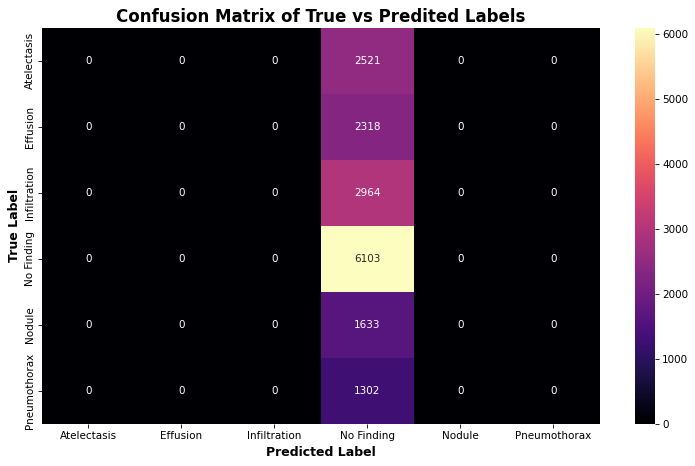

In [217]:
# Confusion matrix for the test data
confusion_matrix_gen(y_true, y_pred, 'magma')

100%|██████████| 85/85 [00:05<00:00, 16.63it/s]


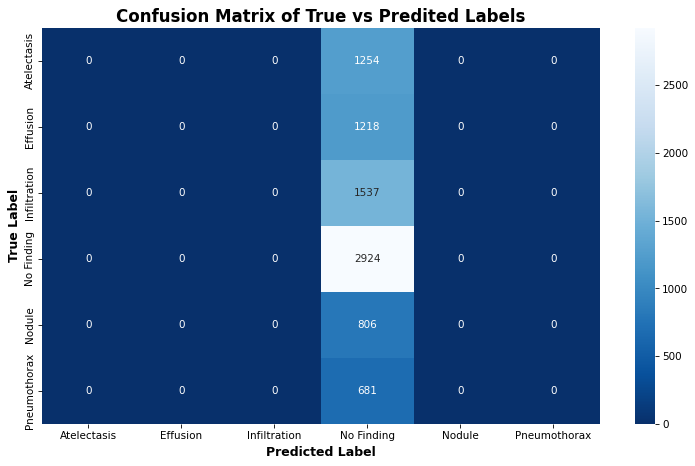

In [218]:
# Confusion matrix for the train data
y_true_test, y_pred_test = y_value_gen(model, test_sampler)
confusion_matrix_gen(y_true_test, y_pred_test, 'Blues_r')

# More metrics evalutaion
Using TorchMetrics

In [219]:
acc = torchmetrics.Accuracy()
f1_score = torchmetrics.F1()
precision = torchmetrics.Precision(num_classes=6, average='micro')   #calculate precision globally across all samples and classes
recall = torchmetrics.Recall(num_classes=6,average='macro')

In [ ]:
acc(model),

In [ ]:
precision(model)

In [ ]:
recall(model)

### Function that generates ROC curve for all labels

In [220]:
def roc_curve_gen(y_true, y_pred):
    '''
    takes true and predicted labels lists as input
    and generates a roc curve for each class label
    '''
    
    fpr = dict()
    tpr = dict()
    threshold = dict()

    target_names = [items[1] for items in class_labels.items()]

    for i in range(len(class_labels)):
        fpr[i], tpr[i], threshold[i] = roc_curve(y_true, y_pred, pos_label=i)

    
    mpl.rcParams['figure.dpi'] = 100
    # Plot ROC curve
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label="ROC Curve of {label}".format(label=target_names[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass')
    plt.legend(loc="lower right", prop={'size': 8})
    plt.show()



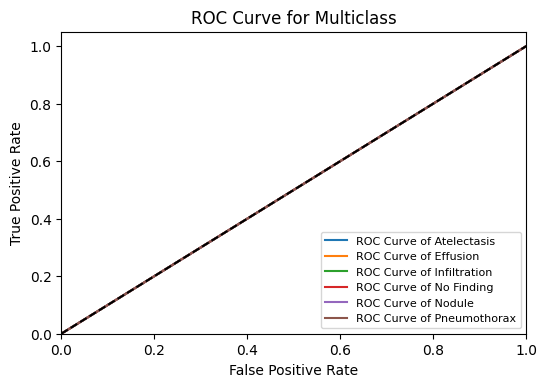

In [221]:
roc_curve_gen(y_true, y_pred)

### Additional metrics per label

In [222]:
def metrics_gen(y_true, y_pred):
    '''
    takes true and predicted labels lists as input
    and returns a summarised metrics report
    '''
    target_names = [items[1] for items in class_labels.items()]
    return metrics.classification_report(y_true, y_pred, output_dict=True, target_names=target_names, zero_division=1)

metrics_gen(y_true, y_pred)

{'Atelectasis': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 2521},
 'Effusion': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 2318},
 'Infiltration': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 2964},
 'No Finding': {'precision': 0.36238940680482157,
  'recall': 1.0,
  'f1-score': 0.5319909344490934,
  'support': 6103},
 'Nodule': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1633},
 'Pneumothorax': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1302},
 'accuracy': 0.36238940680482157,
 'macro avg': {'precision': 0.8937315678008035,
  'recall': 0.16666666666666666,
  'f1-score': 0.08866515574151557,
  'support': 16841},
 'weighted avg': {'precision': 0.7689366753595289,
  'recall': 0.36238940680482157,
  'f1-score': 0.19278787916054968,
  'support': 16841}}